In [1]:
using DynamicalSystems
using DifferentialEquations
using OrdinaryDiffEq
using StaticArrays
using Statistics
using CairoMakie
using JLD

In [2]:
function sigma(x)
    return 1.0 / ( 1.0 + exp( -10.0 * ( x  - ( - 0.25 ) ) ) )
end

function HR(u, p, t)
        
    a, b, c, d, s, xr, r,  I, vs, k1, k2,  el_link  = p
    x1, y1, z1, x2, y2, z2 = u
    
    du1 = y1 + b * x1 ^ 2 - a * x1 ^3 - z1 + I - k1 * ( x1 - vs ) * sigma(x2) + el_link * ( x2 - x1 )
    du2 = c - d * x1 ^2 - y1
    du3 = r * ( s * ( x1 - xr ) - z1 )
    
    du4 = y2 + b * x2 ^ 2 - a * x2 ^3 - z2 + I - k2 * ( x2 - vs ) * sigma(x1) + el_link * ( x1 - x2 )
    du5 = c - d * x2 ^2 - y2
    du6 = r * ( s * ( x2 - xr ) - z2 )
    return SVector(du1, du2, du3,
                    du4, du5, du6)
end
Hs(x, k) = Statistics.mean(x) + k * Statistics.std(x)

Hs (generic function with 1 method)

In [3]:
function peaks(x)
    peaks_ = Float64[]
    len_ = length(x)
    for i in range(2, len_ - 1, step = 1)
        if x[i-1] < x[i] > x[i+1]
            push!(peaks_, x[i])
        end
    end
    return peaks_
end

peaks (generic function with 1 method)

In [31]:
a = 1.0; b = 3.0; c = 1.0; d = 5.0
xr = -1.6; r = 0.01; s = 5.0; I = 4.0; xv = 2.0
k1= -0.17; k2 = -0.17
k = 0.3318
tspan = (0.0, 300000.0)

(0.0, 300000.0)

### k1, k2 = 0.1, 0.1;

In [32]:
p = SA[a, b, c, d, s, xr, r, I, xv, k1, k2, 0.3318]
condition = SA[-0.04471856203156402,
   0.9930479522101472,
   4.4905558028862576,
  -1.6784956837442249,
 -12.985436806629679,
   4.185702440686755
]

6-element SVector{6, Float64} with indices SOneTo(6):
  -0.04471856203156402
   0.9930479522101472
   4.4905558028862576
  -1.6784956837442249
 -12.985436806629679
   4.185702440686755

In [33]:
length(range(0, tspan[2], step = 0.001))

300000001

In [34]:
prob = ODEProblem(HR, condition, tspan, p)
sol = solve(prob, AutoVern9(Rodas5()), abstol = 1e-11, reltol = 1e-11, maxiters = 10000000);

In [38]:
xsum = sol[1, :] + sol[4, :];
println("before: ", length(xsum))

xsum = xsum[floor(Int, length(xsum) / 4):end ]
println("after: ", length(xsum))

Hs1 = Hs(xsum, 6)
length(xsum), Hs1

before: 4699159
after: 3524371


(3524371, 2.4424268819351553)

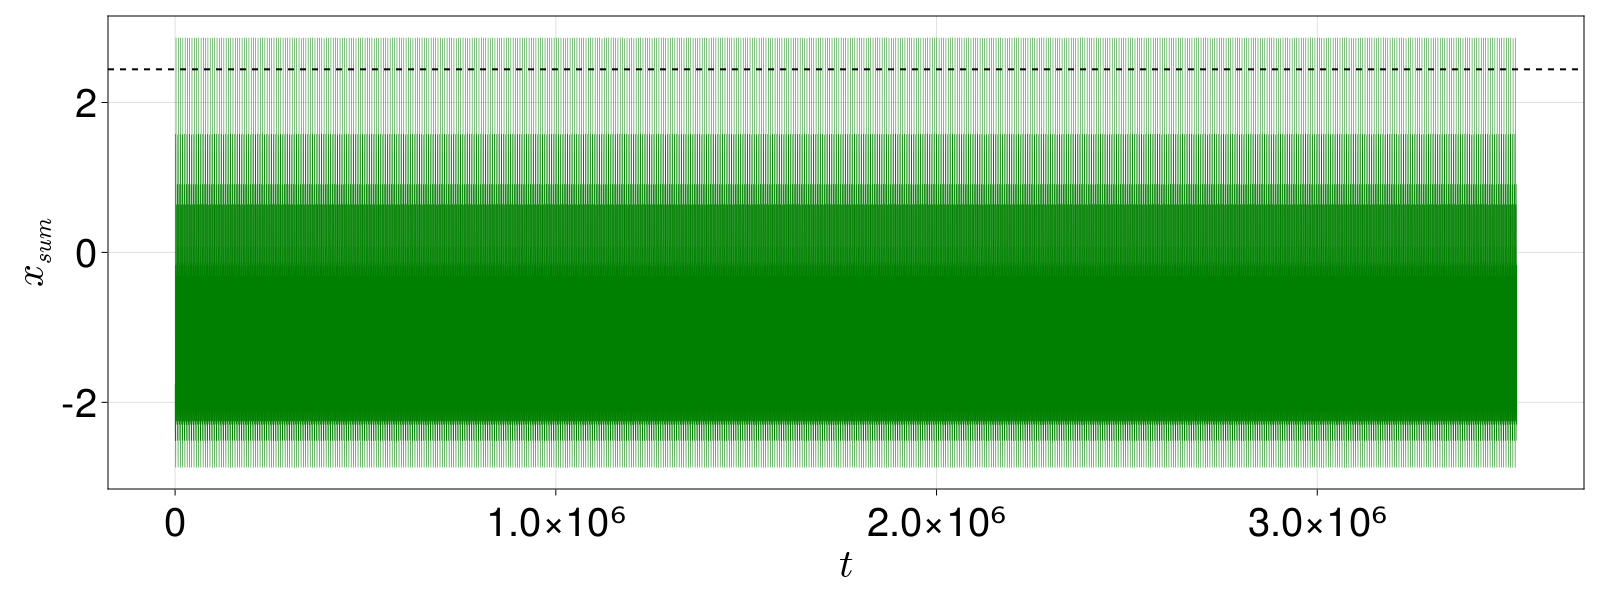

In [40]:
ts, tf = 1, 3524371
f = Figure(resolution = (1600, 600), fontsize = 40)
ax = Axis(f[1, 1], xlabel = L"t", ylabel = L"x_{sum}")
lines!(ax, xsum[ts:end], linewidth = 0.5, color = "green")
hlines!(Hs1, color = "black", linewidth = 2.0, linestyle = :dash)
f

In [ ]:
ts, tf = 100000, 2200000

f = Figure(resolution = (2500, 2500), dpi = 300)
ax = Axis3(f[1, 1],
xlabel = L"x_1", ylabel = L"y_1", zlabel = L"z_1",
xlabelsize = 100, ylabelsize = 100, zlabelsize = 100,
xticklabelsize = 50, yticklabelsize = 50, zticklabelsize = 50,
zticks = range(3.6, 4.2, step = 0.2))
lines!(ax, sol[1, ts:tf], sol[2, ts:tf], sol[3, ts:tf], linewidth = 1.5, color = "blue" )
f

In [11]:
ds = ContinuousDynamicalSystem(HR, condition, p)

6-dimensional continuous dynamical system
 state:       [-1.5, 0.0, 0.0, -2.5, 0.0, 0.0]
 rule f:      HR
 in-place?    false
 jacobian:    ForwardDiff
 parameters:  [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, …, 4.0, 2.0, 0.07, 0.07, 0.01]

In [12]:
LES = lyapunovspectrum(ds, tspan[2]; Ttr = tspan[2]/4, Δt = 1,
                        diffeq = (alg = Vern9(), adaptive = false, dense = false, dt = 0.001)
)
    

6-element Vector{Float64}:
   0.016817892346586184
   0.00944249692193568
  -0.0005518782148920353
   0.0005900636375009583
  -7.210403325604293
 -10.10341112929699

In [178]:
LES = lyapunovspectrum(ds, tspan[2]; Ttr = tspan[2]/4)
    

6-element Vector{Float64}:
  0.006130572006910495
  0.0005717353016003723
 -0.0030015010135140815
 -0.009424315877292741
 -2.8122577516027145
 -4.870719987096388